## Sugerencias para la resolución
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.

## Consignas del Desafío 3

### 1. Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje

Como corpus de texto se una copia de *"Rebelión en la granja"*, de George Orwell. El documento utilizado como fuente contiene el libro en formato EPUB, que es posible parsearlo de manera similar a un archivo HTML. Cabe mencionar que el archivo está escrito en español, de modo que la acentuación y algunos caracteres de este alfabeto serán tenidos en cuenta para integrar el corpus del documento.

In [18]:
from ebooklib import epub
from bs4 import BeautifulSoup

# Cargar el archivo EPUB
book = epub.read_epub("rebelion_granja.epub")

# Extraer texto de cada sección
texts = []
for item in book.get_items():
    if isinstance(item, epub.EpubHtml):
        soup = BeautifulSoup(item.get_content(), "html.parser")
        text = soup.get_text().strip()
        if text:  # solo si no está vacío
            texts.append(text)

# Unir todo
article_text = " ".join(texts).lower()

# Ver un fragmento
print(article_text[:1000])  


un rotundo alegato a favor de la libertad y en contra del totalitarismo que se ha convertido en un clásico de la literatura del siglo xx.
esta sátira de la revolución rusa y el triunfo del estalinismo, escrita en 1945, se ha convertido por derecho propio en un hito de la cultura contemporánea y en uno de los libros más mordaces de todos los tiempos. ante el auge de los animales de la granja solariega, pronto detectamos las semillas del totalitarismo en una organización aparentemente ideal; y en nuestros líderes más carismáticos, la sombra de los opresores más crueles.
«una obra literaria perfecta.» t.s. eliot george orwell
rebelión en la granja
epub r1.0
soporaeternus 07.05.16 la libertad de prensa
concebí por primera vez la idea central de este libro en 1937, pero no lo escribí hasta finales de 1943. una vez escrito, fue evidente que sería muy difícil lograr que se publicara (a pesar de la actual escasez de libros que garantiza que cualquier cosa descriptible como libro «venda»), y de

### 2. Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación

Previo a la tokenización es necesario estructurar el vocabulario que se encuentra en el documento generando para ello diccionarios que asigna índices a cada palabra:

In [19]:
chars_vocab = set(article_text)

# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

Tras crear estos mapas, se debe sustituir cada palabra del vocabulario por su correspondiente índice:

In [20]:
tokenized_text = [char2idx[ch] for ch in article_text]
tokenized_text[:10] 

[16, 38, 36, 47, 61, 45, 16, 38, 66, 61]

Ya habiendo completado la tokenización, se prepara un dataset de entrenamiento para el modelo

In [21]:
import numpy as np

# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
max_context_size = 100
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

### 3. Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.

Se desea hacer pruebas con tres arquitecturas distintas para ver diferencias entre ellas: una red SimpleRNN, una LSTM y una GRU. Para facilitar la creación de arquitecturas, se utiliza una estructura `Sequential` provista por Keras y se intercambia la capa intermedia para trabajar con cada tipo de red. La función que se describe a continuación facilita la selección del modelo que se desea probar en cada momento:

In [22]:
from keras.models import Sequential
from keras.layers import TimeDistributed, CategoryEncoding, SimpleRNN, Dense, LSTM, GRU
from keras.optimizers import Adam

def create_architecture(middle_layer_arch='RNN'):
    model = Sequential()
    vocab_size = len(chars_vocab)

    model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))

    if middle_layer_arch == 'RNN':
        model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
    elif middle_layer_arch == 'LSTM':
        model.add(LSTM(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
    elif middle_layer_arch == 'GRU':
        model.add(GRU(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))

    model.add(Dense(vocab_size, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=1e-3))

    model.summary()
    return model

Para medir el desempeño de la red se usa la **perplejidad** de la red en el conjunto de validación, midiéndola a través de un callback personalizado que se prevee en la guía de resolución. Para optimizar los tiempos de procesamiento, se hacen unos cambios en el callback para:

1. Realizar el cálculo de la perplejidad sobre una muestra del conjunto de validación en lugar de usar el conjunto entero.
2. Calcular la métrica vectorialmente en lugar de iterar mediante bucles *for*.

Además se hace uso de una GPU para el entrenamiento y batchs de 4096 elementos para acelerar todavía más el proceso.

In [23]:
from tensorflow import keras
import tensorflow as tf
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from keras.utils import pad_sequences
from tqdm import tqdm

class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, model_filename="my_model", patience=5):
      # El callback lo inicializamos con secuencias de validación sobre los cuales mediremos la perplejidad en subconjuntos aleatorios
      self.val_data = val_data
      self.history_ppl = history_ppl

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      self.filename=model_filename

      # Nos movemos en todas las secuencias de los datos de validación
      for seq in tqdm(self.val_data, desc="Preprocesando validación"):
        len_seq = len(seq)
        # Armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq) > 0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      if len(self.padded) > 0:
            self.padded = np.vstack(self.padded)
      else:
          self.padded = np.array([])


    def on_epoch_end(self, epoch, logs=None):
        if len(self.padded) == 0:
            print("No validation data provided for PPL.")
            return

        sample_idx = np.random.choice(len(self.padded), size=5000, replace=False)
        predictions = self.model.predict(self.padded[sample_idx], verbose=0)

        # Extraer probabilidades correctas en batch
        sample_targets = np.array(self.target)[sample_idx]
        probs = predictions[np.arange(len(sample_targets)), -1, sample_targets]

        # Perplejidad promedio (sin bucles Python)
        current_score = np.exp(-np.mean(np.log(probs)))
        self.history_ppl.append(current_score)
        print(f"\n mean perplexity: {current_score:.4f} \n")

        # Early stopping
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save(f"{self.filename}.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True

Y ahora se entrenan los modelos:

In [24]:
# Entrenar el modelo usando el callback a la salida de cada epoch.
RNN_history_ppl = []
with tf.device("/GPU:0"):
  RNN_model = create_architecture('RNN')
  hist = RNN_model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val, RNN_history_ppl, "RNN_model")], batch_size=1024)

c:\Users\Juan\miniconda3\envs\NLP\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_2              │ (None, None, 67)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, None, 200)      │        53,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, None, 67)       │        13,467 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,067 (261.98 KB)

 Trainable params: 67,067 (261.98 KB)

 Non-trainable params: 0 (0.00 B)

Preprocesando validación: 100%|██████████| 215/215 [00:00<00:00, 3818.64it/s]

Epoch 1/20


189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 2.9970
 mean perplexity: 10.8746 

Saved new model!
189/189 ━━━━━━━━━━━━━━━━━━━━ 25s 120ms/step - loss: 2.7010
Epoch 2/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 2.2435
 mean perplexity: 9.2780 

Saved new model!
189/189 ━━━━━━━━━━━━━━━━━━━━ 22s 115ms/step - loss: 2.1953
Epoch 3/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 2.0907
 mean perplexity: 8.2625 

Saved new model!
189/189 ━━━━━━━━━━━━━━━━━━━━ 22s 115ms/step - loss: 2.0633
Epoch 4/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 1.9865
 mean perplexity: 7.6423 

Saved new model!
189/189 ━━━━━━━━━━━━━━━━━━━━ 22s 115ms/step - loss: 1.9628
Epoch 5/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 1.8999
 mean perplexity: 7.6613 

189/189 ━━━━━━━━━━━━━━━━━━━━ 22s 115ms/step - loss: 1.8816
Epoch 6/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 1.8316
 mean perplexity: 7.1340 

Saved new model!
189/189 ━━━━━━━━━━━━━━━━━━━━ 22s 115ms/step - loss: 1.

La evolución de la perplejidad para este modelo básico es la siguiente:

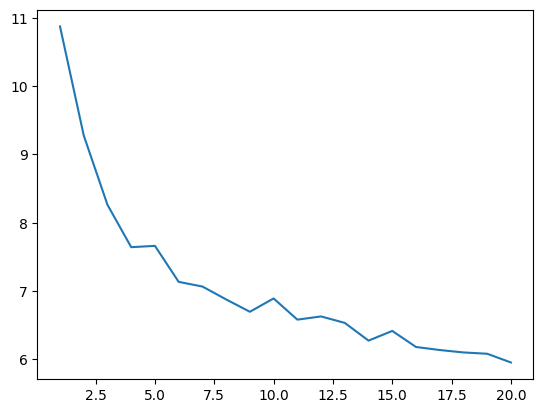

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(RNN_history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=RNN_history_ppl)
plt.show()

Se entrenan también los otros modelos:

In [26]:
LSTM_history_ppl = []
with tf.device("/GPU:0"):
  LSTM_model = create_architecture('LSTM')
  hist = LSTM_model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val, LSTM_history_ppl, "LSTM_model")], batch_size=1024)

c:\Users\Juan\miniconda3\envs\NLP\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_3              │ (None, None, 67)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 200)      │       214,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, None, 67)       │        13,467 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 227,867 (890.11 KB)

 Trainable params: 227,867 (890.11 KB)

 Non-trainable params: 0 (0.00 B)

Preprocesando validación: 100%|██████████| 215/215 [00:00<00:00, 3535.43it/s]

Epoch 1/20


189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 3.1411
 mean perplexity: 12.6629 

Saved new model!
189/189 ━━━━━━━━━━━━━━━━━━━━ 57s 288ms/step - loss: 2.8551
Epoch 2/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 2.3846
 mean perplexity: 9.9364 

Saved new model!
189/189 ━━━━━━━━━━━━━━━━━━━━ 53s 281ms/step - loss: 2.3108
Epoch 3/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 2.1568
 mean perplexity: 9.1271 

Saved new model!
189/189 ━━━━━━━━━━━━━━━━━━━━ 53s 283ms/step - loss: 2.1250
Epoch 4/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 2.0449
 mean perplexity: 8.3122 

Saved new model!
189/189 ━━━━━━━━━━━━━━━━━━━━ 53s 283ms/step - loss: 2.0249
Epoch 5/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 1.9697
 mean perplexity: 8.2679 

Saved new model!
189/189 ━━━━━━━━━━━━━━━━━━━━ 54s 283ms/step - loss: 1.9538
Epoch 6/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - loss: 1.9100
 mean perplexity: 8.3535 

189/189 ━━━━━━━━━━━━━━━━━━━━ 54s 286ms/step - loss: 1.

In [27]:
GRU_history_ppl = []
with tf.device("/GPU:0"):
  GRU_model = create_architecture('GRU')
  hist = GRU_model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val, GRU_history_ppl, "GRU_model")], batch_size=1024)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_4              │ (None, None, 67)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, None, 200)      │       161,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, None, 67)       │        13,467 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 174,867 (683.07 KB)

 Trainable params: 174,867 (683.07 KB)

 Non-trainable params: 0 (0.00 B)

Preprocesando validación: 100%|██████████| 215/215 [00:00<00:00, 2717.14it/s]

Epoch 1/20


189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 3.1467
 mean perplexity: 11.3175 

Saved new model!
189/189 ━━━━━━━━━━━━━━━━━━━━ 59s 295ms/step - loss: 2.7480
Epoch 2/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 2.2473
 mean perplexity: 9.3513 

Saved new model!
189/189 ━━━━━━━━━━━━━━━━━━━━ 54s 283ms/step - loss: 2.1919
Epoch 3/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 2.0598
 mean perplexity: 8.6209 

Saved new model!
189/189 ━━━━━━━━━━━━━━━━━━━━ 53s 283ms/step - loss: 2.0237
Epoch 4/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - loss: 1.9257
 mean perplexity: 7.7810 

Saved new model!
189/189 ━━━━━━━━━━━━━━━━━━━━ 54s 284ms/step - loss: 1.8977
Epoch 5/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - loss: 1.8192
 mean perplexity: 7.2769 

Saved new model!
189/189 ━━━━━━━━━━━━━━━━━━━━ 53s 283ms/step - loss: 1.7964
Epoch 6/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 1.7320
 mean perplexity: 7.1372 

Saved new model!
189/189 ━━━━━━━━━━━━━━━━━━━━ 51s 270m

Y la evolución comparativa de los modelos queda así:

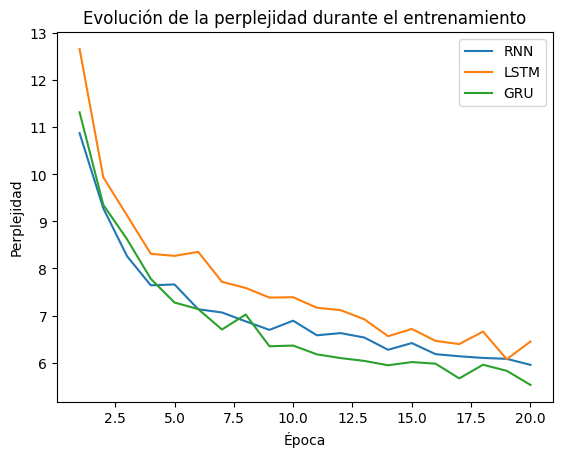

In [28]:
# Rango de epochs
epoch_count = range(1, len(RNN_history_ppl) + 1)

# Graficar cada curva
sns.lineplot(x=epoch_count, y=RNN_history_ppl, label="RNN")
sns.lineplot(x=epoch_count, y=LSTM_history_ppl, label="LSTM")
sns.lineplot(x=epoch_count, y=GRU_history_ppl, label="GRU")

# Títulos y etiquetas
plt.xlabel("Época")
plt.ylabel("Perplejidad")
plt.title("Evolución de la perplejidad durante el entrenamiento")
plt.legend()
plt.show()

### 4. Generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.

Esta consigna refiere a la generación de texto relevante para el contexto de entrenamiento a partir de una semilla de texto particular. Se observan los efectos de una búsqueda *Greedy*, donde se toma la palabra más probable que define el modelo para formar la frase de salida, sin importar el resultado global. Usando la función entregada por la cátedra para probar el modelo GRU sobre la frase "*el hombre es*", se obtiene:

In [34]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

input_text='el hombre es'
generate_seq(GRU_model, input_text, max_length=max_context_size, n_words=100)

'el hombre estaba en la casa. se había perdido a la casa de la granja animal de la granja animal de la granja ani'

Se observa como el modelo "alucina" y entra en un bucle. La utilización de técnicas estocásticas puede ayudar a salir de estos máximos locales y encontrar frases menos repetitivas:

In [ ]:
from scipy.special import softmax

# funcionalidades para hacer encoding y decoding
def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])


# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

# predicción con beam search
salidas = beam_search(GRU_model, num_beams=10, num_words=100, input='el hombre es')
salidas[0]
# veamos las salidas
decode(salidas[0])

'el hombre estaban de la granja animales de la granja animal de la granja animal de la granja animal de la granja'

Aparentemente no hay demasiados cambios usando el método determinista. Usar una mayor temperatura debería resultar en una variación mayor de las palabras:

In [38]:
# predicción con beam search estocástico
salidas = beam_search(GRU_model, num_beams=10, num_words=100, input='el hombre es', mode="sto", temp=2)
salidas[0]
# veamos las salidas
decode(salidas[0])

'el hombre estaba el molino de viento. se había pagado de que no se pudieron a los animales eran todos los animan'

Se observa que la clase generada no se queda atascada en un bucle.